In [1]:
# importing needed packages
import logging
from graph_recommender_system import GraphRecommendationSystem, load_data
import pandas as pd
import time

In [2]:
# Logging settings
logging.basicConfig(filename='info.log', level=logging.INFO)
# Initialize and connect to database
db = GraphRecommendationSystem("bolt://localhost:7687", "neo4j", "")
# NB this will run for ~8 hours

In [3]:
total_time = time.time()
# Split the data in train and test data
(train, test) = db.get_file_paths("active1000", 0.7)
# Importing train data from files to database (only need to run once) 
# db.import_data("active1000", train)  # NB this will run for ~8 hours
#logging.info(f"Import data took: {((time.time() - total_time)/60.0)} minutes") 

In [4]:
# Creating dataframes of the data to be used in evaluating the results from the recommendations
df_test = load_data("active1000", test)
df_train = load_data("active1000", train)

In [5]:
# Fetching users to be used in recommendations
df_test = df_test[df_test["url"] != "http://adressa.no"]
user_df = df_test.groupby(['userId']).size().reset_index(name='counts')
users = user_df["userId"].tolist()
len(users)

988

# Evaluation basics  
[Source](https://bond-kirill-alexandrovich.medium.com/precision-and-recall-in-recommender-systems-and-some-metrics-stuff-ca2ad385c5f8)

TP = True positives  
TN = True negatives  
FP = False positives  
FN = False negatives  

Accuracy = (TP + TN) / (TP+TN+FP+FN)  
Precision = TP / (TP + FP)  
Recall = TP / (TP+FN)  

In [7]:
def precision(test_data_user, predictions):
    if(len(predictions) == 0):
        return
    true_positives = test_data_user[test_data_user["url"].isin(predictions["url"])]
    true_positive_false_positive = predictions
    return len(true_positives)/len(true_positive_false_positive) # TP / (TP + FP)

def precision_per_user(df_predictions, df_test_data):
    test_data = df_test_data[["userId", "url"]]
    precisions = test_data.groupby('userId').apply(lambda user: precision(user, df_predictions[df_predictions["userId"] == user["userId"].iloc[0]]))
    return precisions

In [37]:
def recall(test_data_user, predictions):
    true_positives = test_data_user[test_data_user["url"].isin(predictions["url"])]
    true_positives_false_negatives = test_data_user
    return len(true_positives)/len(true_positives_false_negatives)

def recall_per_user(df_predictions, df_test_data):
    test_data = df_test_data[["userId", "url"]]
    recalls = test_data.groupby('userId').apply(lambda user: recall(user, df_predictions[df_predictions["userId"] == user["userId"].iloc[0]]))
    return recalls

# Prediction: Predict articles by nearest neighbor and popularity

In [9]:
# Predict all users on popularity (uncomment to run)
start_time = time.time()
#predictions_raw_df = db.predict_on_popularity(users, None) # NB: runs for ~12 hours
#predictions_raw_df.to_feather("predictions_popularity_all_users_v2.feather")
logging.info(f"Prediction took: {((time.time() - start_time)/60.0)} minutes, or hours: {((time.time() - start_time)/3600.0)}")


<AxesSubplot:>

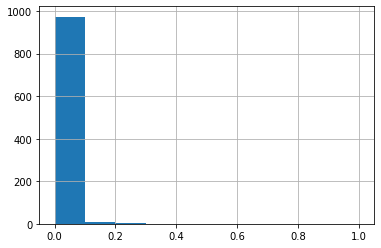

In [19]:
# Evaluating: 10 predictions per user, for all users, on popularity
predictions_popularity = pd.read_feather("predictions_popularity_all_users.feather")
precision_popularity = precision_per_user(predictions_popularity, df_test)
precision_popularity.hist(bins=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])

In [20]:
precision_popularity.mean()

0.002327935222672065

<AxesSubplot:>

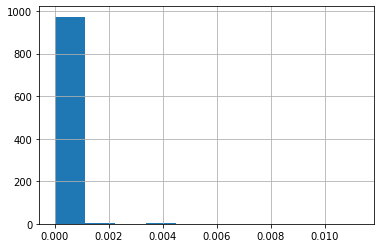

In [40]:
recall_popularity = recall_per_user(predictions_popularity, df_test)
recall_popularity.hist()

In [28]:
recall_popularity.mean()

5.482049322814496e-05

<AxesSubplot:xlabel='recall'>

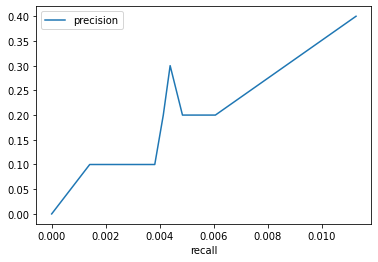

In [63]:
recall_precision_plot_popularity = pd.concat([precision_popularity, recall_popularity], keys=["precision", "recall"], axis=1)
recall_precision_plot_popularity = recall_precision_plot_popularity.sort_values(["recall"])
recall_precision_plot_popularity.plot.line(x="recall", y="precision")

# Prediction: Finding similar users and recommend their newest read articles

In [11]:
# Prediction all users. Finding similar users and recommend their newest read articles
start_time = time.time()
#predictions = db.predict_on_bestfriends_newest(users)
#predictions.to_feather("predictions_on_best_friend_all_users_v2.feather")
logging.info(f"Prediction on bestfriend took: {((time.time() - start_time)/60.0)} minutes, or hours: {((time.time() - start_time)/3600.0)}")
pd.set_option('display.max_colwidth', None)


<AxesSubplot:>

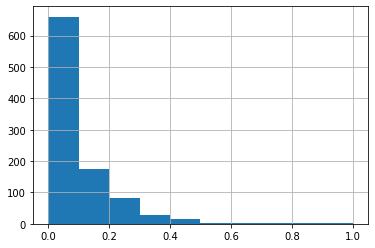

In [21]:
predictions_newest = pd.read_feather("predictions_on_best_friend_all_users.feather")
precision_newest = precision_per_user(predictions_newest, df_test)
precision_newest.hist(bins=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])

In [22]:
precision_newest.mean()

0.05476190476190476

<AxesSubplot:>

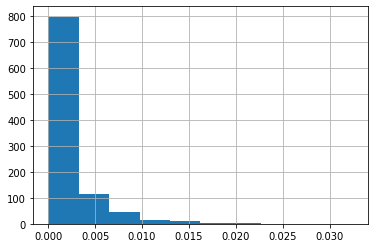

In [39]:
recall_newest = recall_per_user(predictions_newest, df_test)
recall_newest.hist()

In [30]:
recall_newest.mean()

0.001606781808669075

<AxesSubplot:xlabel='recall'>

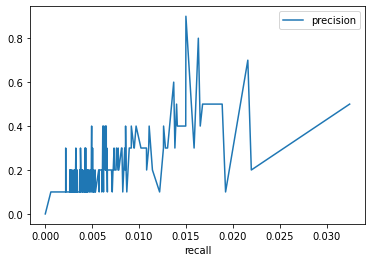

In [62]:
recall_precision_plot_newest = pd.concat([precision_newest, recall_newest], keys=["precision", "recall"], axis=1)
recall_precision_plot_newest = recall_precision_plot_newest.sort_values(["recall"])
recall_precision_plot_newest.plot.line(x="recall", y="precision")

# Cold start problem

In [33]:
# Cold start popularity recommendation
user = "newUser" # This ID does not exist in the database
cold_start_predictions = db.predict_on_popularity(["newUser"])
cold_start_predictions


,userId,url
0,newUser,http://adressa.no/pluss/magasin/2017/01/14/fiv...
1,newUser,http://adressa.no/pluss/magasin/2017/02/25/det...
2,newUser,http://adressa.no/pluss/magasin/2016/02/01/tro...
3,newUser,http://adressa.no/bolig/boligguiden/trondheim/...
4,newUser,http://adressa.no/pluss/magasin/2017/01/14/fiv...
5,newUser,http://adressa.no/nyheter/utenriks/2017/02/12/...
6,newUser,http://adressa.no/100sport/sprek/her-ligger-de...
7,newUser,http://adressa.no/pluss/nyheter/2017/02/06/kun...
8,newUser,http://adressa.no/pluss/okonomi/2017/02/11/hun...
9,newUser,http://adressa.no/pluss/magasin/2017/01/16/hvo...


In [34]:
# Cold start popularity recommendation with categories
categories = ["sport", "okonomi", "nyheter"] # Simulates a user inputs its preferred categories
user = "newUser" # This ID does not exist in the database
cold_start_categories_predictions = db.predict_on_popularity(["newUser"], categories)
cold_start_categories_predictions

,userId,url
0,newUser,http://adressa.no/nyheter/utenriks/2017/02/12/...
1,newUser,http://adressa.no/pluss/okonomi/2017/02/11/hun...
2,newUser,http://adressa.no/pluss/nyheter/2017/02/06/kun...
3,newUser,http://adressa.no/pluss/nyheter/2017/02/06/kun...
4,newUser,http://adressa.no/nyheter/trondheim/2017/01/04...
5,newUser,http://adressa.no/pluss/nyheter/2017/02/06/kun...
6,newUser,http://adressa.no/nyheter/nordtrondelag/2017/0...
7,newUser,http://adressa.no/pluss/nyheter/2017/02/06/kun...
8,newUser,http://adressa.no/nyheter/okonomi/2017/02/12/%...
9,newUser,http://adressa.no/pluss/nyheter/2017/02/27/de-...
